In [7]:
import numpy as np
import pandas as pd
import shutil, time, os, tqdm, requests, random, copy
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.manifold import TSNE

In [3]:
def set_seed(seed = 16):
    np.random.seed(seed)
    torch.manual_seed(seed)

##### Set up DataSet and DataLoader classes for pretraining.

In [32]:
from imutils import paths

class GSDDataset(torch.utils.data.Dataset):
    def __init__(self, transform = None):
        self.root_dir = 'data/processed/YOLOCrops/German_Shepherd/dog'
        self.image_paths = list(paths.list_images(self.root_dir))
        self.transform = transform

    def __getitem__(self, index):
        sample = cv2.imread(self.image_paths[index])
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return len(self.image_paths)
    
class Standardize:
    def __call__(self, sample):
        sample = cv2.resize(sample, (224, 224))
        trans = torchvision.transforms.ToTensor()
        sample = trans(sample)
        return sample
    
class Augment:
    def __init__(self, s=0.5):
        self.s = s
        self.transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                              transforms.RandomResizedCrop(224,(0.8,1.0)),
                                              transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.2*self.s)], p = 0.8),
                                                                  transforms.RandomGrayscale(p=0.2)
                                                                 ])])
    def __call__(self, sample):
        sample = self.transforms(sample)
        return sample

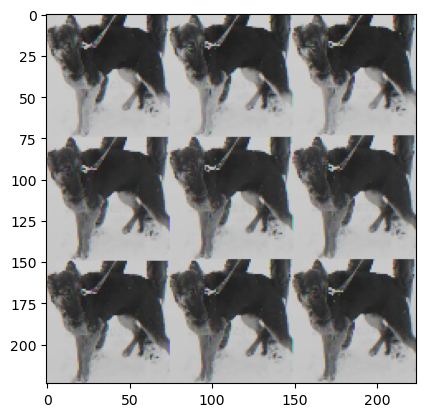

In [34]:
composed = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), Augment()])#, torchvision.transforms.ToTensor()])
dataset = GSDDataset(transform=composed)
dataset.__len__()
plt.imshow(dataset[0].reshape(224, 224, 3))
# rows = 27
# columns = 11
# fig = plt.figure(figsize=(20, 20))
# for i in range(1, dataset.__len__()):
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(dataset[i].reshape(224, 224, 3))
#     plt.axis('off')
